# Import Libraries

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm

from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import OneHotEncoder
import datetime

In [2]:
def return_series(csv_path):
    """
    
    """
    
    def parse(x):
        return datetime.datetime.strptime(x, '%m/%d/%Y %H')
    
    df = pd.read_csv(csv_path, parse_dates=[['Date','Hour']], date_parser=parse)
    
    conditions = [
    df['Plaza ID'].eq(21) | df['Plaza ID'].eq(1),
    df['Plaza ID'].eq(22) | df['Plaza ID'].eq(2),
    df['Plaza ID'].eq(23) | df['Plaza ID'].eq(3),
    df['Plaza ID'].eq(24) | df['Plaza ID'].eq(4),
    df['Plaza ID'].eq(25) | df['Plaza ID'].eq(5),
    df['Plaza ID'].eq(26) | df['Plaza ID'].eq(6),
    df['Plaza ID'].eq(27) | df['Plaza ID'].eq(7),
    df['Plaza ID'].eq(28) | df['Plaza ID'].eq(8),
    df['Plaza ID'].eq(29) | df['Plaza ID'].eq(9),
    df['Plaza ID'].eq(30) | df['Plaza ID'].eq(11)
    ]
    choices = [
        'Triboro Bronx',
        'Triboro Manhattan',
        'Whitestone',
        'Henry Hudson',
        'Marine Parkway',
        'Cross Bay',
        'Queens Midtown',
        'Brooklyn Battery',
        'Throgs Neck',
        'Verrazano'
    ]
    df['plaza_id'] = np.select(conditions, choices, 0)
    
    df['total_count'] = df['# Vehicles - E-ZPass'] + df['# Vehicles - VToll']
    
    sub_df = df[['Date_Hour', 'plaza_id', 'total_count']]
    sub_df.columns = ['datetime', 'plaza_id', 'total_count']
    sub_df.set_index('datetime', inplace=True)
    sub_df = sub_df.groupby('plaza_id')['total_count'].resample('1D').sum()
    
    return sub_df


In [4]:
df = return_series('mta.csv')

In [7]:
_df = df.unstack().T

In [8]:
_df = _df['2018':].copy()
_df

plaza_id,Brooklyn Battery,Cross Bay,Henry Hudson,Marine Parkway,Queens Midtown,Throgs Neck,Triboro Bronx,Triboro Manhattan,Verrazano,Whitestone
datetime,,,,,,,,,,
2018-01-01,29163,13705,46540,12118,54907,98346,110224,30551,81923,109286
2018-01-02,47160,21875,60610,19887,67000,106264,129574,35356,95649,117211
2018-01-03,54005,24607,67983,22067,71725,115952,136213,38937,103506,123974
2018-01-04,20484,8303,14502,6167,26625,28406,50867,13270,37820,38114
2018-01-05,38007,16839,49850,13929,55153,80477,105945,29308,74375,91229
...,...,...,...,...,...,...,...,...,...,...
2020-09-08,55105,24644,60591,25524,66662,106502,130435,34153,100146,121270
2020-09-09,56553,22692,62026,22821,67238,104707,128069,35541,99250,118513
2020-09-10,55672,20742,60627,20495,65909,100158,125216,34303,97574,114546


In [74]:

def date_features(_df):
    _df['month'] = _df.index.month
    _df['dayofweek'] = _df.index.dayofweek
    _df['year'] = _df.index.year
    _df['week'] = _df.index.isocalendar().week
    _df['day'] = _df.index.day
    _df['quarter'] = _df.index.quarter


    conditions = [
        (_df.index >= '2020-03-21') & (_df.index < '2020-06-08'),
        (_df.index >= '2020-06-08') & (_df.index < '2020-06-22'),
        (_df.index >= '2020-06-22') & (_df.index < '2020-07-06'),
        (_df.index >= '2020-07-06') & (_df.index < '2020-07-19'),
        (_df.index >= '2020-07-19')
    ]

    choices = [
        0,
        1,
        2,
        3,
        4
    ]

    _df['Phase'] = np.select(conditions, choices, -1)
    _df['weekend'] = (_df.index.dayofweek>4).astype(int)
    
    return _df

In [48]:
ohe = OneHotEncoder(drop='first')
categorical_columns = ['month', 'dayofweek', 'quarter', 'Phase']
_df_ohe = ohe.fit_transform(_df[categorical_columns]).toarray()
_df_ohe_df = pd.DataFrame(data = _df_ohe,
                           index = _df.index,
                          columns = ohe.get_feature_names(categorical_columns))

_df_merged = _df.merge(_df_ohe_df, left_index=True, right_index=True)
_df_merged

,Brooklyn Battery,Cross Bay,Henry Hudson,Marine Parkway,Queens Midtown,Throgs Neck,Triboro Bronx,Triboro Manhattan,Verrazano,Whitestone,...,dayofweek_5,dayofweek_6,quarter_2,quarter_3,quarter_4,Phase_0,Phase_1,Phase_2,Phase_3,Phase_4
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01,29163,13705,46540,12118,54907,98346,110224,30551,81923,109286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-02,47160,21875,60610,19887,67000,106264,129574,35356,95649,117211,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-03,54005,24607,67983,22067,71725,115952,136213,38937,103506,123974,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-04,20484,8303,14502,6167,26625,28406,50867,13270,37820,38114,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-05,38007,16839,49850,13929,55153,80477,105945,29308,74375,91229,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-08,55105,24644,60591,25524,66662,106502,130435,34153,100146,121270,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2020-09-09,56553,22692,62026,22821,67238,104707,128069,35541,99250,118513,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2020-09-10,55672,20742,60627,20495,65909,100158,125216,34303,97574,114546,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [50]:
_df_ohe_df['weekend'] = _df['weekend']

In [52]:
tr_start,tr_end = '2018-01-01','2020-08-20'
te_start,te_end = '2020-08-21','2020-09-12'
tra = _df_merged[tr_start:tr_end]['Brooklyn Battery'].dropna()
tes = _df_merged[te_start:te_end]['Brooklyn Battery'].dropna()
exog_train = _df_ohe_df[tr_start:tr_end]
exog_test = _df_ohe_df[te_start:te_end]

In [53]:
tra

datetime
2018-01-01    29163
2018-01-02    47160
2018-01-03    54005
2018-01-04    20484
2018-01-05    38007
              ...  
2020-08-16    26879
2020-08-17    51279
2020-08-18    54168
2020-08-19    52481
2020-08-20    57221
Freq: D, Name: Brooklyn Battery, Length: 963, dtype: int64

In [33]:
_df_ohe_df

,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,...,week_51,week_52,quarter_2,quarter_3,quarter_4,Phase_0,Phase_1,Phase_2,Phase_3,Phase_4
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2020-09-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2020-09-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [41]:
stepwise_fit = auto_arima(tra, start_p=0, start_q=0,
                          exogenous = exog_train,
                         max_p=3, max_q=3, m=12,
                         seasonal=True,
                         d=None, trace=True,
                         error_action='ignore',   
                         suppress_warnings=True,  
                         stepwise=True)           

stepwise_fit.summary()

Performing stepwise search to minimize aic
Fit ARIMA: (0, 0, 0)x(1, 0, 1, 12) (constant=True); AIC=20554.514, BIC=20953.859, Time=5.960 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 12) (constant=True); AIC=20550.525, BIC=20940.129, Time=0.599 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 12) (constant=True); AIC=20250.138, BIC=20649.482, Time=6.341 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 12) (constant=True); AIC=20337.784, BIC=20737.129, Time=6.935 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 12) (constant=False); AIC=26206.313, BIC=26591.047, Time=0.595 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 12) (constant=True); AIC=20248.179, BIC=20642.654, Time=1.675 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 1, 12) (constant=True); AIC=20250.139, BIC=20649.483, Time=7.140 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 1, 12) (constant=True); AIC=20252.140, BIC=20656.354, Time=6.645 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 12) (constant=True); AIC=20242.854, BIC=20642.198, Time=1.901 seconds
Fit ARIMA: (2, 0, 0)x(1, 0, 0, 12) (constant=Tr

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  963
Model:               SARIMAX(1, 0, 1)   Log Likelihood              -10038.697
Date:                Thu, 17 Sep 2020   AIC                          20241.393
Time:                        15:56:49   BIC                          20640.738
Sample:                    01-01-2018   HQIC                         20393.450
                         - 08-20-2020                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept     191.8958    712.196      0.269      0.788   -1203.982    1587.773
month_2     -2237.8797   9910.841     -0.226      0.821   -2.17e+04    1.72e+04
month_3     -6086.2799   1.32e+04     -0.461      0.645   -3.19e+04    1.98e+04
month_4     -6228.1384   6149.855     -1.013      0.311   -1.83e+04    5825.355
month_5      1968.2020   6040.859      0.326      0.745   -9871.664    1.38e+04
month_6      5877.6534   9009.712      0.652      0.514   -1.18e+04    2.35e+04
month_7     -2511.7502   6809.527     -0.369      0.712   -1.59e+04    1.08e+04
month_8     -7004.0153   6220.137     -1.126      0.260   -1.92e+04    5187.228
month_9     -2868.6880   7578.862     -0.379      0.705   -1.77e+04     1.2e+04
month_10     1076.9451   1.04e+04      0.104      0.917   -1.93e+04    2.14e+04
month_11     4319.9173   4577.744      0.944      0.345   -4652.296    1.33e+04
month_12     1.576e+04   4285.733      3.676      0.000    7355.878    2.42e+04
dayofweek_1  7671.1698   1022.963      7.499      0.000    5666.200    9676.139
dayofweek_2  8146.2793   1015.473      8.022      0.000    6155.989    1.01e+04
dayofweek_3  1.093e+04   1095.165      9.982      0.000    8785.676    1.31e+04
dayofweek_4  8765.6536   1095.343      8.003      0.000    6618.821    1.09e+04
dayofweek_5 -2938.0804   1127.933     -2.605      0.009   -5148.788    -727.373
dayofweek_6 -4874.6500    969.675     -5.027      0.000   -6775.178   -2974.122
year_2019    4392.5383   1686.777      2.604      0.009    1086.517    7698.560
year_2020    4462.4596   2598.616      1.717      0.086    -630.734    9555.653
week_2        4.29e+04   2408.574     17.812      0.000    3.82e+04    4.76e+04
week_3       4.118e+04   4511.402      9.128      0.000    3.23e+04       5e+04
week_4       4.212e+04   6081.702      6.925      0.000    3.02e+04     5.4e+04
week_5       4.453e+04   6965.530      6.393      0.000    3.09e+04    5.82e+04
week_6       4.765e+04   8762.515      5.438      0.000    3.05e+04    6.48e+04
week_7       4.717e+04   9812.304      4.808      0.000    2.79e+04    6.64e+04
week_8       4.442e+04   1.16e+04      3.835      0.000    2.17e+04    6.71e+04
week_9       4.875e+04   1.19e+04      4.084      0.000    2.54e+04    7.21e+04
week_10      5.062e+04   1.28e+04      3.952      0.000    2.55e+04    7.57e+04
week_11      5.036e+04   1.34e+04      3.758      0.000    2.41e+04    7.66e+04
week_12      4.529e+04   1.35e+04      3.355      0.001    1.88e+04    7.17e+04
week_13      5.156e+04   1.47e+04      3.511      0.000    2.28e+04    8.03e+04
week_14      4.933e+04    1.5e+04      3.286      0.001    1.99e+04    7.88e+04
week_15      5.126e+04   1.55e+04      3.302      0.001    2.08e+04    8.17e+04
week_16      5.009e+04   1.58e+04      3.174      0.002    1.92e+04     8.1e+04
week_17      5.103e+04   1.57e+04      3.248      0.001    2.02e+04    8.18e+04
week_18       5.09e+04   1.52e+04      3.341      0.001     2.1e+04    8.08e+04
week_19      4.918e+04   1.52e+04      3.

In [62]:
model_SARIMAX = SARIMAX(tra,order=(7,0,7),exog = exog_train,
                        freq='D', enforce_stationarity=False, enforce_invertibility=False)
results = model_SARIMAX.fit()
results.summary()

C:\Users\albert\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Brooklyn Battery   No. Observations:                  963
Model:               SARIMAX(7, 0, 7)   Log Likelihood              -10037.424
Date:                Thu, 17 Sep 2020   AIC                          20156.849
Time:                        16:14:07   BIC                          20356.179
Sample:                    01-01-2018   HQIC                         20232.777
                         - 08-20-2020                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
month_2      3.376e+04   2664.891     12.670      0.000    2.85e+04     3.9e+04
month_3      3.238e+04   9032.411      3.585      0.000    1.47e+04    5.01e+04
month_4      6717.7006   6854.836      0.980      0.327   -6717.531    2.02e+04
month_5      1.133e+04   3509.964      3.229      0.001    4453.549    1.82e+04
month_6      9892.9593   4699.850      2.105      0.035     681.423    1.91e+04
month_7      8209.0555   3745.233      2.192      0.028     868.533    1.55e+04
month_8      5235.5685   3807.081      1.375      0.169   -2226.173    1.27e+04
month_9      1.109e+04   4060.639      2.731      0.006    3132.265     1.9e+04
month_10     6349.7149   5008.654      1.268      0.205   -3467.067    1.62e+04
month_11     9426.3306   5936.214      1.588      0.112   -2208.435    2.11e+04
month_12     1.032e+04   4378.665      2.356      0.018    1732.994    1.89e+04
dayofweek_1  2.393e+04   5767.076      4.149      0.000    1.26e+04    3.52e+04
dayofweek_2  2.428e+04   8894.333      2.730      0.006    6851.982    4.17e+04
dayofweek_3  2.678e+04   9952.133      2.691      0.007    7276.052    4.63e+04
dayofweek_4  2.437e+04   1.01e+04      2.424      0.015    4661.418    4.41e+04
dayofweek_5  4827.6316   6046.797      0.798      0.425   -7023.872    1.67e+04
dayofweek_6  2822.8850   4611.043      0.612      0.540   -6214.593    1.19e+04
quarter_2    2.794e+04   5305.400      5.267      0.000    1.75e+04    3.83e+04
quarter_3    2.454e+04   4629.487      5.300      0.000    1.55e+04    3.36e+04
quarter_4    2.609e+04   3080.113      8.471      0.000    2.01e+04    3.21e+04
Phase_0     -3.475e+04   4087.999     -8.501      0.000   -4.28e+04   -2.67e+04
Phase_1      -1.77e+04   1.32e+04     -1.337      0.181   -4.36e+04    8241.377
Phase_2     -1.328e+04   1.27e+04     -1.043      0.297   -3.82e+04    1.17e+04
Phase_3     -6095.1406   1.71e+04     -0.357      0.721   -3.95e+04    2.74e+04
Phase_4     -1951.7852   1.44e+04     -0.135      0.892   -3.02e+04    2.63e+04
weekend      7650.5167   5704.329      1.341      0.180   -3529.762    1.88e+04
ar.L1          -0.1344      0.035     -3.806      0.000      -0.204      -0.065
ar.L2          -0.1189      0.047     -2.534      0.011      -0.211      -0.027
ar.L3          -0.0999      0.053     -1.871      0.061      -0.205       0.005
ar.L4          -0.0893      0.048     -1.846      0.065      -0.184       0.006
ar.L5          -0.0976      0.038     -2.591      0.010      -0.171      -0.024
ar.L6          -0.1174      0.033     -3.574      0.000      -0.182      -0.053
ar.L7           0.8644      0.031     28.339      0.000       0.805       0.924
ma.L1           0.6943      0.043     15.976      0.000       0.609       0.779
ma.L2           0.6466      0.069      9.382      0.000       0.512       0.782
ma.L3           0.5516      0.093      5.927      0.000       0.369       0.734
ma.L4           0.4805      0.101      4.780      0.000       0.283       0.678
ma.L5           0.4523      0.089      5.

ARIMA model MSE:5450.9740293133445


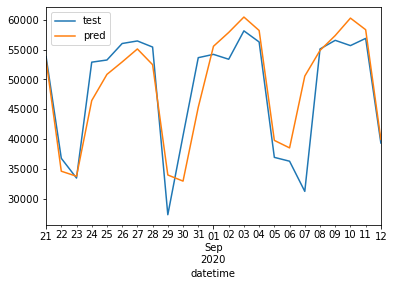

In [63]:

pred = results.predict(te_start,te_end, exog = exog_test)
print('ARIMA model MSE:{}'.format(np.sqrt(mean_squared_error(tes,pred))))
pd.DataFrame({'test':tes,'pred':pred}).plot();plt.show()

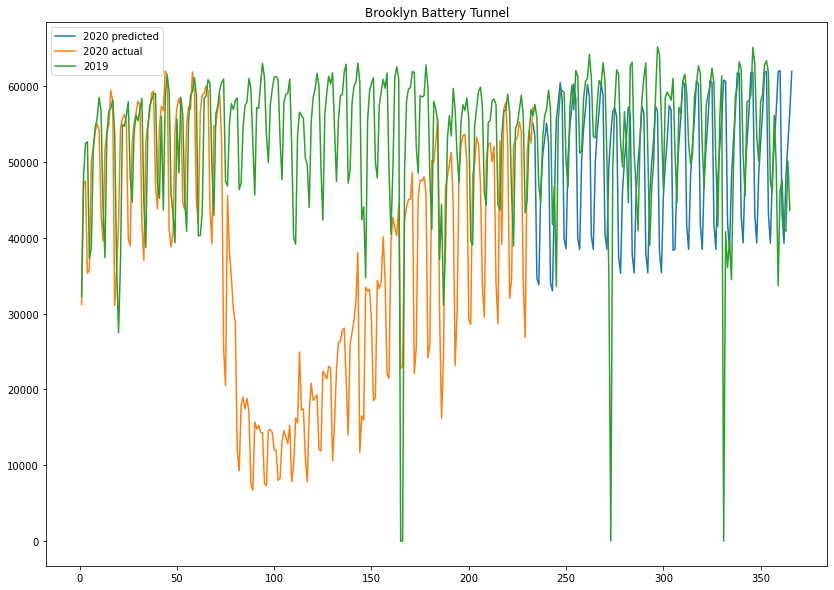

In [117]:
pred_1 = results.predict('2020-08-20', '2020-12-31', exog=_far_ohe_df)
plt.figure(figsize=(14,10))
plt.plot(pred_1.index.dayofyear,pred_1, label = '2020 predicted')

plt.plot(tra['2020'].index.dayofyear, tra['2020'], label = '2020 actual')
plt.plot(tra['2019'].index.dayofyear, tra['2019'], label = '2019')
plt.title('Brooklyn Battery Tunnel')
plt.legend()

In [108]:
_x_pred_1 = pred_1.index.dayofyear

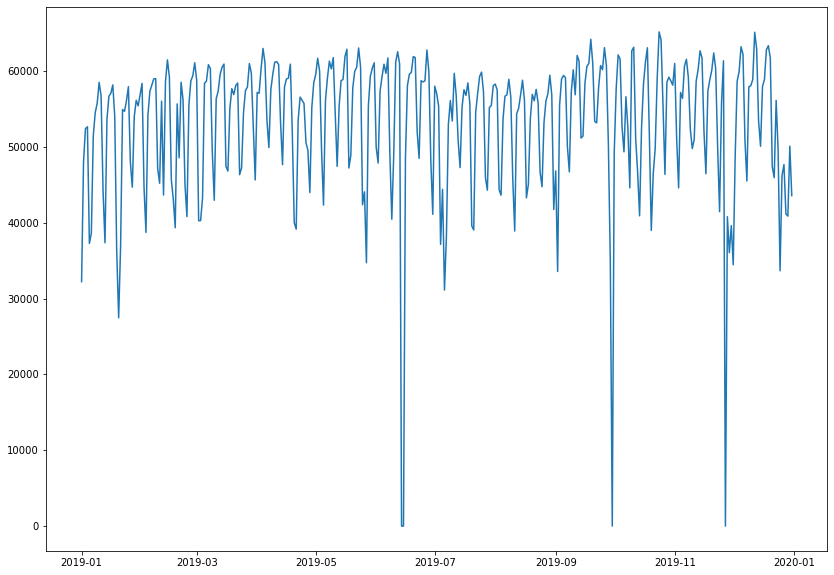

In [98]:
plt.figure(figsize=(14,10))
plt.plot(tra['2019'])

In [103]:
tra.index.dayofyear

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            224, 225, 226, 227, 228, 229, 230, 231, 232, 233],
           dtype='int64', name='datetime', length=963)

In [87]:
pred_far = pd.DataFrame()
pred_far['date'] = pd.date_range(start='2020-08-21',end='2020-12-31')

In [88]:
pred_far.set_index('date', inplace=True)

In [89]:
pred_far = date_features(pred_far)

In [122]:
_far_ohe = ohe.transform(pred_far[categorical_columns]).toarray()
_far_ohe_df = pd.DataFrame(data = _far_ohe,
                          index = pred_far.index,
                          columns = ohe.get_feature_names(categorical_columns))
_far_ohe_df['weekend'] = pred_far['weekend']
_far_ohe_df

,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,...,dayofweek_6,quarter_2,quarter_3,quarter_4,Phase_0,Phase_1,Phase_2,Phase_3,Phase_4,weekend
date,,,,,,,,,,,,,,,,,,,,,
2020-08-21,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
2020-08-22,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2020-08-23,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2020-08-24,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
2020-08-25,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
2020-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0
2020-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0


In [123]:
conditions = [
    
    
]

choices = [
    
    
]

_far_ohe_df['Phase_4'] = np.where(_far_ohe_df.index >= '2020-09-30', 0.0, 1.0)
_far_ohe_df['Phase_0'] = np.where(_far_ohe_df.index >= '2020-09-30', 1.0, 0.0)

In [120]:
_far_ohe_df.tail()

,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,...,dayofweek_6,quarter_2,quarter_3,quarter_4,Phase_0,Phase_1,Phase_2,Phase_3,Phase_4,weekend
date,,,,,,,,,,,,,,,,,,,,,
2020-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1
2020-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
2020-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
2020-12-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
2020-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0


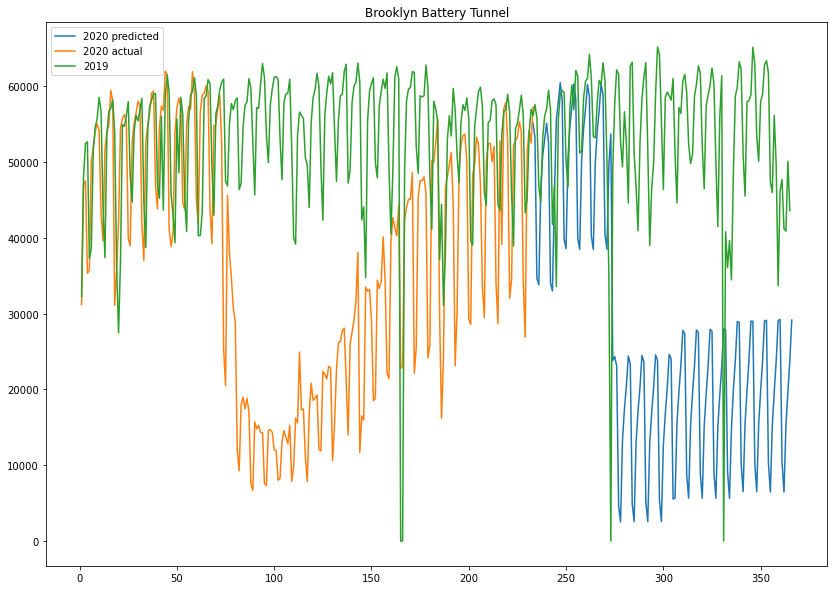

In [124]:
pred_1 = results.predict('2020-08-20', '2020-12-31', exog=_far_ohe_df)
plt.figure(figsize=(14,10))
plt.plot(pred_1.index.dayofyear,pred_1, label = '2020 predicted')

plt.plot(tra['2020'].index.dayofyear, tra['2020'], label = '2020 actual')
plt.plot(tra['2019'].index.dayofyear, tra['2019'], label = '2019')
plt.title('Brooklyn Battery Tunnel')
plt.legend()

In [125]:
tr_start,tr_end = '2018-01-01','2020-08-20'
te_start,te_end = '2020-08-21','2020-09-12'
tra = _df_merged[tr_start:tr_end]['Queens Midtown'].dropna()
tes = _df_merged[te_start:te_end]['Queens Midtown'].dropna()
exog_train = _df_ohe_df[tr_start:tr_end]
exog_test = _df_ohe_df[te_start:te_end]

In [126]:
_far_ohe = ohe.transform(pred_far[categorical_columns]).toarray()
_far_ohe_df = pd.DataFrame(data = _far_ohe,
                          index = pred_far.index,
                          columns = ohe.get_feature_names(categorical_columns))
_far_ohe_df['weekend'] = pred_far['weekend']
_far_ohe_df

,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,...,dayofweek_6,quarter_2,quarter_3,quarter_4,Phase_0,Phase_1,Phase_2,Phase_3,Phase_4,weekend
date,,,,,,,,,,,,,,,,,,,,,
2020-08-21,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
2020-08-22,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2020-08-23,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2020-08-24,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
2020-08-25,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
2020-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0
2020-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0


In [127]:
model_SARIMAX = SARIMAX(tra,order=(7,0,7),exog = exog_train,
                        freq='D', enforce_stationarity=False, enforce_invertibility=False)
results = model_SARIMAX.fit()
results.summary()

C:\Users\albert\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Queens Midtown   No. Observations:                  963
Model:               SARIMAX(7, 0, 7)   Log Likelihood              -10377.770
Date:                Thu, 17 Sep 2020   AIC                          20837.539
Time:                        16:56:23   BIC                          21036.869
Sample:                    01-01-2018   HQIC                         20913.468
                         - 08-20-2020                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
month_2      4.994e+04   3668.423     13.615      0.000    4.28e+04    5.71e+04
month_3      4.754e+04   1.55e+04      3.059      0.002    1.71e+04     7.8e+04
month_4      1.029e+04   9470.295      1.086      0.277   -8274.193    2.88e+04
month_5      1.656e+04   6602.875      2.507      0.012    3613.793    2.95e+04
month_6      1.381e+04   7546.881      1.830      0.067    -983.413    2.86e+04
month_7      1.316e+04   7646.106      1.721      0.085   -1824.336    2.81e+04
month_8      9907.3149   7434.109      1.333      0.183   -4663.271    2.45e+04
month_9      1.579e+04   8811.775      1.792      0.073   -1476.622    3.31e+04
month_10      1.09e+04   9675.890      1.126      0.260   -8068.687    2.99e+04
month_11     1.459e+04   1.02e+04      1.435      0.151   -5335.755    3.45e+04
month_12     1.437e+04   6266.099      2.294      0.022    2091.825    2.67e+04
dayofweek_1  3.281e+04   7511.936      4.367      0.000    1.81e+04    4.75e+04
dayofweek_2  3.363e+04   1.32e+04      2.545      0.011    7727.978    5.95e+04
dayofweek_3  3.744e+04   1.28e+04      2.925      0.003    1.24e+04    6.25e+04
dayofweek_4  3.713e+04   1.61e+04      2.300      0.021    5489.074    6.88e+04
dayofweek_5  8013.4644   1.01e+04      0.793      0.428   -1.18e+04    2.78e+04
dayofweek_6  6543.4158   1.22e+04      0.538      0.591   -1.73e+04    3.04e+04
quarter_2    4.065e+04   8526.656      4.767      0.000    2.39e+04    5.74e+04
quarter_3    3.886e+04   8243.095      4.715      0.000    2.27e+04     5.5e+04
quarter_4    3.985e+04   5210.833      7.648      0.000    2.96e+04    5.01e+04
Phase_0     -5.456e+04   5356.611    -10.186      0.000   -6.51e+04   -4.41e+04
Phase_1     -3.485e+04    2.7e+04     -1.289      0.197   -8.78e+04    1.81e+04
Phase_2     -2.971e+04   2.79e+04     -1.065      0.287   -8.44e+04     2.5e+04
Phase_3     -2.437e+04   3.47e+04     -0.702      0.482   -9.24e+04    4.36e+04
Phase_4     -1.836e+04   3.18e+04     -0.577      0.564   -8.08e+04     4.4e+04
weekend      1.456e+04   8591.249      1.694      0.090   -2281.658    3.14e+04
ar.L1          -0.0872      0.022     -3.969      0.000      -0.130      -0.044
ar.L2          -0.0807      0.024     -3.421      0.001      -0.127      -0.034
ar.L3          -0.0803      0.024     -3.393      0.001      -0.127      -0.034
ar.L4          -0.0818      0.022     -3.685      0.000      -0.125      -0.038
ar.L5          -0.0848      0.021     -4.037      0.000      -0.126      -0.044
ar.L6          -0.0880      0.021     -4.241      0.000      -0.129      -0.047
ar.L7           0.9038      0.020     45.343      0.000       0.865       0.943
ma.L1           0.6531      0.030     21.680      0.000       0.594       0.712
ma.L2           0.6277      0.038     16.382      0.000       0.553       0.703
ma.L3           0.5899      0.043     13.626      0.000       0.505       0.675
ma.L4           0.5847      0.048     12.217      0.000       0.491       0.679
ma.L5           0.5728      0.048     11.

ARIMA model MSE:5647.018976825543


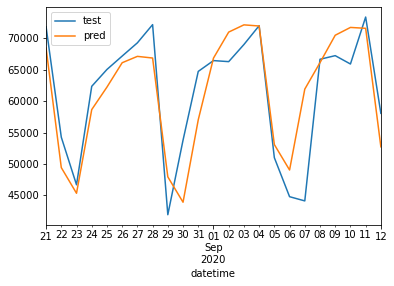

In [128]:

pred = results.predict(te_start,te_end, exog = exog_test)
print('ARIMA model MSE:{}'.format(np.sqrt(mean_squared_error(tes,pred))))
pd.DataFrame({'test':tes,'pred':pred}).plot();plt.show()

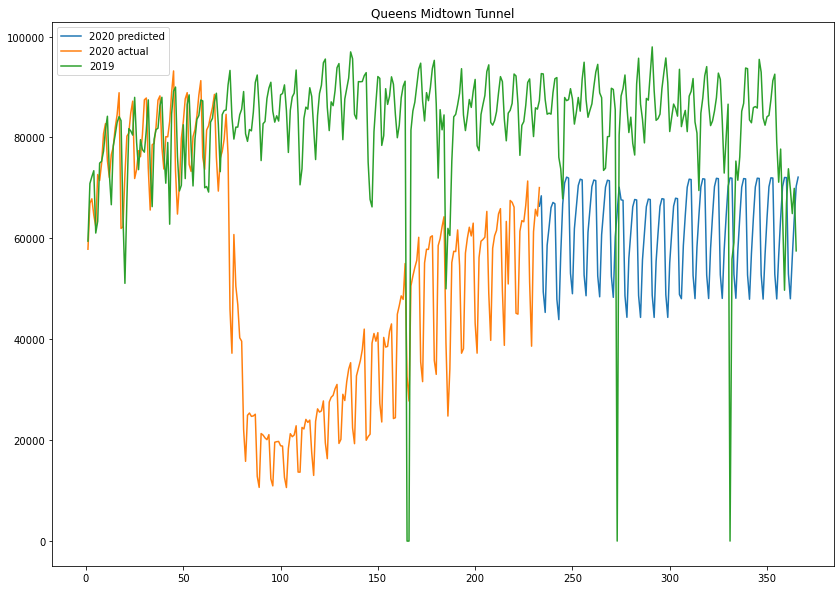

In [130]:
pred_1 = results.predict('2020-08-20', '2020-12-31', exog=_far_ohe_df)
plt.figure(figsize=(14,10))
plt.plot(pred_1.index.dayofyear,pred_1, label = '2020 predicted')

plt.plot(tra['2020'].index.dayofyear, tra['2020'], label = '2020 actual')
plt.plot(tra['2019'].index.dayofyear, tra['2019'], label = '2019')
plt.title('Queens Midtown Tunnel')
plt.legend()

In [9]:
df = pd.read_csv('2018_and_on.csv')
df.columns = ['datetime','plaza_id','total_count']
df

,datetime,plaza_id,total_count
0,2020-09-05 00:00:00,Triboro Bronx,2314
1,2020-09-05 01:00:00,Triboro Bronx,1600
2,2020-09-05 02:00:00,Triboro Bronx,1151
3,2020-09-05 03:00:00,Triboro Bronx,983
4,2020-09-05 04:00:00,Triboro Bronx,1111
...,...,...,...
393728,2018-01-01 19:00:00,Verrazano,4668
393729,2018-01-01 20:00:00,Verrazano,4146
393730,2018-01-01 21:00:00,Verrazano,3056
393731,2018-01-01 22:00:00,Verrazano,2918


In [10]:
df['datetime'] = pd.to_datetime(df['datetime'])
df

,datetime,plaza_id,total_count
0,2020-09-05 00:00:00,Triboro Bronx,2314
1,2020-09-05 01:00:00,Triboro Bronx,1600
2,2020-09-05 02:00:00,Triboro Bronx,1151
3,2020-09-05 03:00:00,Triboro Bronx,983
4,2020-09-05 04:00:00,Triboro Bronx,1111
...,...,...,...
393728,2018-01-01 19:00:00,Verrazano,4668
393729,2018-01-01 20:00:00,Verrazano,4146
393730,2018-01-01 21:00:00,Verrazano,3056
393731,2018-01-01 22:00:00,Verrazano,2918


In [11]:
df.set_index('datetime', inplace=True)
df

,plaza_id,total_count
datetime,,
2020-09-05 00:00:00,Triboro Bronx,2314
2020-09-05 01:00:00,Triboro Bronx,1600
2020-09-05 02:00:00,Triboro Bronx,1151
2020-09-05 03:00:00,Triboro Bronx,983
2020-09-05 04:00:00,Triboro Bronx,1111
...,...,...
2018-01-01 19:00:00,Verrazano,4668
2018-01-01 20:00:00,Verrazano,4146
2018-01-01 21:00:00,Verrazano,3056


In [15]:
_df = df.groupby('plaza_id')['total_count'].resample('1D').sum()
_df

plaza_id          datetime  
Brooklyn Battery  2018-01-01     28500
                  2018-01-02     47160
                  2018-01-03     54005
                  2018-01-04     20484
                  2018-01-05     38007
                                 ...  
Whitestone        2020-09-01    120023
                  2020-09-02    121942
                  2020-09-03    129804
                  2020-09-04    142667
                  2020-09-05    132535
Name: total_count, Length: 9790, dtype: int64

In [20]:
_df_unstack = _df.unstack().T

In [25]:
_df_unstack

plaza_id,Brooklyn Battery,Cross Bay,Henry Hudson,Marine Parkway,Quessn Midtown,Throgs Neck,Triboro Bronx,Triboro Manhattan,Verrazano,Whitestone
datetime,,,,,,,,,,
2018-01-01,28500,13226,45681,11729,53427,96408,107518,29590,79469,106796
2018-01-02,47160,21875,60610,19887,67000,106264,129574,35356,95649,117211
2018-01-03,54005,24607,67983,22067,71725,115952,136213,38937,103506,123974
2018-01-04,20484,8303,14502,6167,26625,28406,50867,13270,37820,38114
2018-01-05,38007,16839,49850,13929,55153,80477,105945,29308,74375,91229
...,...,...,...,...,...,...,...,...,...,...
2020-09-01,54205,22050,58137,21816,66451,102514,123835,34637,98659,120023
2020-09-02,53388,21632,61046,21038,66285,100477,121336,34427,99886,121942
2020-09-03,58136,25051,66150,25955,69008,109383,132064,38136,103172,129804


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000000139927C8>,
      dtype=object)

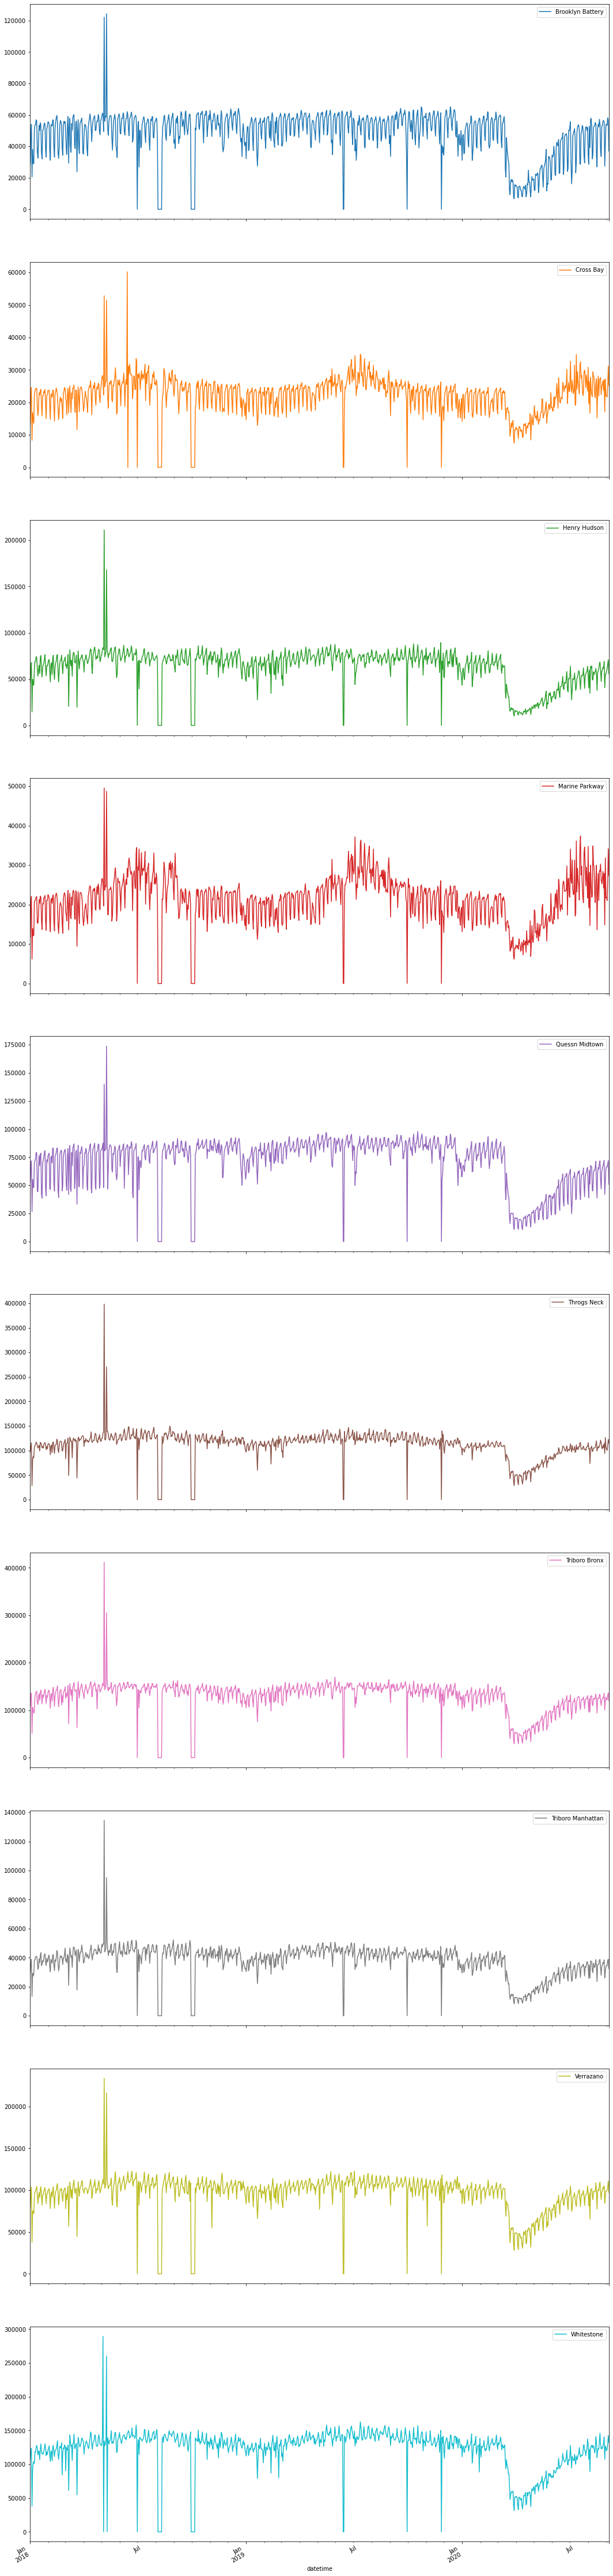

In [33]:
_df_unstack.plot(subplots=True, figsize=(18,90))

In [34]:
_df_unstack.describe()

plaza_id,Brooklyn Battery,Cross Bay,Henry Hudson,Marine Parkway,Quessn Midtown,Throgs Neck,Triboro Bronx,Triboro Manhattan,Verrazano,Whitestone
count,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000
mean,48167.472932,22295.709908,63432.754852,21252.890705,71258.582227,112031.234934,129281.126660,38040.430031,96525.988764,123015.129724
std,14608.810137,5793.045759,19939.520241,6230.511205,22220.615961,27542.396207,33063.541036,10730.967999,21863.446873,30157.491419
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,42719.500000,19430.500000,58111.500000,17438.000000,63813.000000,107806.500000,123306.000000,34971.000000,93759.000000,120408.000000
50%,53327.000000,23501.000000,69728.000000,22148.000000,80189.000000,118016.000000,139089.000000,41003.000000,102324.000000,131048.000000
75%,58005.500000,25433.000000,75322.000000,24668.000000,85456.000000,125179.000000,147613.500000,44149.500000,107856.500000,139184.500000
max,124290.000000,60196.000000,211128.000000,49536.000000,173820.000000,398139.000000,411801.000000,134658.000000,233739.000000,289376.000000


C:\Users\albert\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


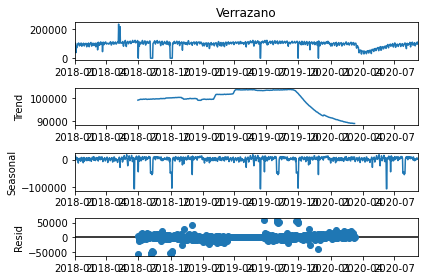

In [42]:
decomposed_df_verrazno = sm.tsa.seasonal_decompose(_df_unstack['Verrazano'], freq= 360)

figure = decomposed_df_verrazno.plot()


In [43]:
_df_unstack.columns

Index(['Brooklyn Battery', 'Cross Bay', 'Henry Hudson', 'Marine Parkway',
       'Quessn Midtown', 'Throgs Neck', 'Triboro Bronx', 'Triboro Manhattan',
       'Verrazano', 'Whitestone'],
      dtype='object', name='plaza_id')

In [44]:
_df_unstack['Brooklyn Battery'].diff().iloc[1:]

datetime
2018-01-02    18660.0
2018-01-03     6845.0
2018-01-04   -33521.0
2018-01-05    17523.0
2018-01-06    -8693.0
               ...   
2020-09-01      553.0
2020-09-02     -817.0
2020-09-03     4748.0
2020-09-04    -1856.0
2020-09-05   -19309.0
Freq: D, Name: Brooklyn Battery, Length: 978, dtype: float64

In [99]:
_BBT['2018':'2019']

plaza_id,Brooklyn Battery
datetime,
2018-01-01,28500
2018-01-02,47160
2018-01-03,54005
2018-01-04,20484
2018-01-05,38007
...,...
2019-12-27,47674
2019-12-28,41165
2019-12-29,40876


In [100]:
tr_start,tr_end = '2018-01-01','2020-08-20'
te_start,te_end = '2020-08-21','2020-09-05'
tra = _BBT[tr_start:tr_end].dropna()
tes = _BBT[te_start:te_end].dropna()
# exog_train = _albert_daily_features.drop(columns = ['y', 'count_shifted_7', 'count_shifted_28'])[tr_start:tr_end].dropna()
# exog_test = _albert_daily_features.drop(columns = ['y', 'count_shifted_7', 'count_shifted_28'],axis = 1)[te_start:te_end].dropna()

In [76]:
stepwise_fit = auto_arima(_BBT, start_p=0, start_q=0, 
#                           exogenous = _albert_daily_features.drop(columns = ['y', 'count_shifted_7', 'count_shifted_28'])[tr_start:te_end].dropna(), 
                          information_criterion='oob',
                         max_p=3, max_q=3, m=12, out_of_sample_size=39,
                         seasonal=True,
                         d=None, trace=True,
                         error_action='ignore',   
                         suppress_warnings=True,  
                         stepwise=True)           

stepwise_fit.summary()

Performing stepwise search to minimize oob
Fit ARIMA: (0, 1, 0)x(1, 0, 1, 12) (constant=True); AIC=20609.587, BIC=20629.129, Time=1.162 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 12) (constant=True); AIC=20684.857, BIC=20694.628, Time=0.068 seconds
Fit ARIMA: (1, 1, 0)x(1, 0, 0, 12) (constant=True); AIC=20603.909, BIC=20623.451, Time=0.799 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 1, 12) (constant=True); AIC=20493.865, BIC=20513.407, Time=1.476 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 12) (constant=False); AIC=20682.881, BIC=20687.766, Time=0.050 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 12) (constant=True); AIC=20579.680, BIC=20594.336, Time=0.195 seconds
Fit ARIMA: (0, 1, 1)x(1, 0, 1, 12) (constant=True); AIC=20490.973, BIC=20515.400, Time=2.068 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 2, 12) (constant=True); AIC=20479.258, BIC=20503.686, Time=5.044 seconds
Fit ARIMA: (0, 1, 1)x(1, 0, 0, 12) (constant=True); AIC=20535.010, BIC=20554.552, Time=1.010 seconds
Fit ARIMA: (0, 1, 1)x(1, 0, 2, 12) (constant=Tr

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  979
Model:             SARIMAX(2, 1, 2)x(0, 0, 2, 12)   Log Likelihood              -10120.342
Date:                            Wed, 16 Sep 2020   AIC                          20256.683
Time:                                    14:52:58   BIC                          20295.767
Sample:                                         0   HQIC                         20271.554
                                            - 979                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     39.4992     31.154      1.268      0.205     -21.562     100.561
ar.L1          1.0219      0.048     21.468      0.000       0.929       1.115
ar.L2         -0.5986      0.025    -23.544      0.000      -0.648      -0.549
ma.L1         -1.4563      0.049    -29.863      0.000      -1.552      -1.361
ma.L2          0.6187      0.047     13.255      0.000       0.527       0.710
ma.S.L12      -0.2268      0.025     -9.037      0.000      -0.276      -0.178
ma.S.L24       0.0306      0.040      0.769      0.442      -0.047       0.108
sigma2      5.279e+07   2.27e-05   2.32e+12      0.000    5.28e+07    5.28e+07
===================================================================================
Ljung-Box (Q):                      591.36   Jarque-Bera (JB):              8229.26
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                             0.53
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.69e+28. Standard errors may be unstable.
"""

In [101]:
model_SARIMAX = SARIMAX(tra,order=(2,1,2), seasonal_order = (0,0,2,12), freq='D', enforce_stationarity=False, enforce_invertibility=False)
results = model_SARIMAX.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   Brooklyn Battery   No. Observations:                  963
Model:             SARIMAX(2, 1, 2)x(0, 0, 2, 12)   Log Likelihood               -9714.544
Date:                            Wed, 16 Sep 2020   AIC                          19443.089
Time:                                    15:01:16   BIC                          19476.972
Sample:                                01-01-2018   HQIC                         19456.009
                                     - 08-20-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5720      0.040    -14.383      0.000      -0.650      -0.494
ar.L2          0.3761      0.036     10.556      0.000       0.306       0.446
ma.L1          0.1973      0.019     10.571      0.000       0.161       0.234
ma.L2         -0.9370      0.028    -33.717      0.000      -0.991      -0.883
ma.S.L12      -0.2665      0.028     -9.402      0.000      -0.322      -0.211
ma.S.L24      -0.0848      0.032     -2.611      0.009      -0.148      -0.021
sigma2      5.311e+07   4.89e-10   1.09e+17      0.000    5.31e+07    5.31e+07
===================================================================================
Ljung-Box (Q):                     1273.75   Jarque-Bera (JB):              4312.90
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                             0.69
Prob(H) (two-sided):                  0.02   Kurtosis:                        13.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.02e+32. Standard errors may be unstable.
"""

ARIMA model MSE:8893.91692122099


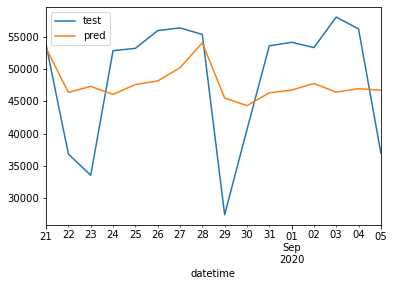

In [107]:

pred = results.predict(te_start,te_end)
print('ARIMA model MSE:{}'.format(np.sqrt(mean_squared_error(tes['Brooklyn Battery'],pred))))
pd.DataFrame({'test':tes['Brooklyn Battery'],'pred':pred}).plot();plt.show()

ARIMA model MSE:8060.447776315925


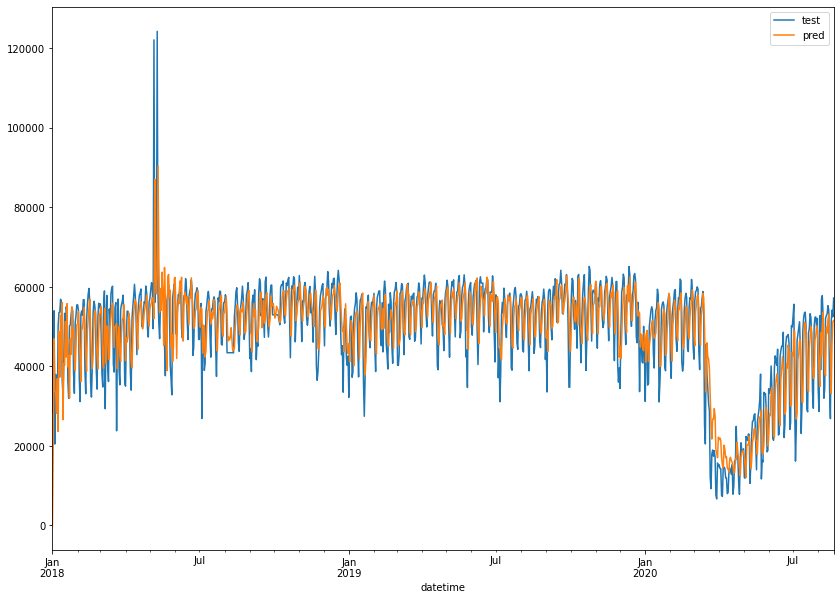

In [109]:
from sklearn.metrics import mean_squared_error
pred = results.predict(tr_start,tr_end)
print('ARIMA model MSE:{}'.format(np.sqrt(mean_squared_error(tra['Brooklyn Battery'],pred))))
pd.DataFrame({'test':tra['Brooklyn Battery'],'pred':pred}).plot(figsize=(14,10));plt.show()

In [110]:
_BBT

plaza_id,Brooklyn Battery
datetime,
2018-01-01,28500
2018-01-02,47160
2018-01-03,54005
2018-01-04,20484
2018-01-05,38007
...,...
2020-09-01,54205
2020-09-02,53388
2020-09-03,58136


In [137]:
_BBT = _df_unstack[['Brooklyn Battery']].copy()

In [138]:
_BBT['month'] = _BBT.index.month
_BBT['dayofweek'] = _BBT.index.weekday
_BBT['weekend'] = (_BBT.index.dayofweek>4).astype(int)
_BBT

plaza_id,Brooklyn Battery,month,dayofweek,weekend
datetime,,,,
2018-01-01,28500,1,0,0
2018-01-02,47160,1,1,0
2018-01-03,54005,1,2,0
2018-01-04,20484,1,3,0
2018-01-05,38007,1,4,0
...,...,...,...,...
2020-09-01,54205,9,1,0
2020-09-02,53388,9,2,0
2020-09-03,58136,9,3,0


In [114]:
# month_dummies = pd.get_dummies(_BBT['month'])
# month_dummies.columns = ['month-' + str(m) for m in range(1,13)]
# # month_dummies
# week_dummies = pd.get_dummies(_BBT['dayofweek'])
# week_dummies.columns = ['dayofweek-' + str(w) for w in range(0,7)]
# # week_dummies
# _BBT = pd.concat([_BBT, month_dummies, week_dummies], axis=1).drop(columns = ['month', 'dayofweek'])

In [115]:
_BBT

,Brooklyn Battery,weekend,month-1,month-2,month-3,month-4,month-5,month-6,month-7,month-8,...,month-10,month-11,month-12,dayofweek-0,dayofweek-1,dayofweek-2,dayofweek-3,dayofweek-4,dayofweek-5,dayofweek-6
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01,28500,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2018-01-02,47160,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2018-01-03,54005,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2018-01-04,20484,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2018-01-05,38007,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-01,54205,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2020-09-02,53388,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2020-09-03,58136,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [134]:
pd.set_option('display.max_rows', 100)
_BBT['2020-03':].head(100)

,Brooklyn Battery,weekend,month-1,month-2,month-3,month-4,month-5,month-6,month-7,month-8,...,month-10,month-11,month-12,dayofweek-0,dayofweek-1,dayofweek-2,dayofweek-3,dayofweek-4,dayofweek-5,dayofweek-6
datetime,,,,,,,,,,,,,,,,,,,,,
2020-03-01,41835,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2020-03-02,56532,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2020-03-03,58810,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2020-03-04,59073,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2020-03-05,60015,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2020-03-06,59403,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2020-03-07,43890,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2020-03-08,39207,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2020-03-09,54748,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [139]:
conditions = [
    (_BBT.index >= '2020-03-21') & (_BBT.index < '2020-06-08'),
    (_BBT.index >= '2020-06-08') & (_BBT.index < '2020-06-22'),
    (_BBT.index >= '2020-06-22') & (_BBT.index < '2020-07-06'),
    (_BBT.index >= '2020-07-06') & (_BBT.index < '2020-07-19'),
    (_BBT.index >= '2020-07-19')
]

choices = [
    0,
    1,
    2,
    3,
    4
]

_BBT['Phase'] = np.select(conditions, choices, -1)
_BBT


plaza_id,Brooklyn Battery,month,dayofweek,weekend,Phase
datetime,,,,,
2018-01-01,28500,1,0,0,5
2018-01-02,47160,1,1,0,5
2018-01-03,54005,1,2,0,5
2018-01-04,20484,1,3,0,5
2018-01-05,38007,1,4,0,5
...,...,...,...,...,...
2020-09-01,54205,9,1,0,4
2020-09-02,53388,9,2,0,4
2020-09-03,58136,9,3,0,4


In [143]:
ohe = OneHotEncoder(drop='first')
categorical_columns = ['month', 'dayofweek','weekend','Phase']
_BBT_ohe = ohe.fit_transform(_BBT[categorical_columns]).toarray()
_BBT_ohe_df = pd.DataFrame(data = _BBT_ohe,
                           index = _BBT.index,
                          columns = ohe.get_feature_names(categorical_columns))

_BBT_merged = _BBT[['Brooklyn Battery']].merge(_BBT_ohe_df, left_index=True, right_index=True)
_BBT_merged

,Brooklyn Battery,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,...,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,weekend_1,Phase_1,Phase_2,Phase_3,Phase_4,Phase_5
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01,28500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2018-01-02,47160,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2018-01-03,54005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2018-01-04,20484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2018-01-05,38007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-01,54205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2020-09-02,53388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2020-09-03,58136,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [145]:
tr_start,tr_end = '2018-01-01','2020-08-20'
te_start,te_end = '2020-08-21','2020-09-05'
tra = _BBT_merged[tr_start:tr_end].dropna()
tes = _BBT_merged[te_start:te_end].dropna()
exog_train = _BBT_merged.drop(columns = ['Brooklyn Battery'])[tr_start:tr_end].dropna()
exog_test = _BBT_merged.drop(columns = ['Brooklyn Battery'])[te_start:te_end].dropna()

In [146]:
stepwise_fit = auto_arima(_BBT_merged['Brooklyn Battery'], start_p=0, start_q=0, 
                          exogenous = _BBT_merged.drop(columns = ['Brooklyn Battery']).dropna(), 
                          information_criterion='oob',
                         max_p=3, max_q=3, m=12, out_of_sample_size=39,
                         seasonal=True,
                         d=None, trace=True,
                         error_action='ignore',   
                         suppress_warnings=True,  
                         stepwise=True)           

stepwise_fit.summary()

Performing stepwise search to minimize oob
Fit ARIMA: (0, 0, 0)x(1, 0, 1, 12) (constant=True); AIC=20117.167, BIC=20249.103, Time=9.914 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 12) (constant=True); AIC=20113.351, BIC=20235.514, Time=0.378 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 12) (constant=True); AIC=19943.797, BIC=20075.734, Time=4.615 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 12) (constant=True); AIC=19983.852, BIC=20115.788, Time=4.428 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 12) (constant=False); AIC=25849.733, BIC=25967.009, Time=0.368 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 12) (constant=True); AIC=19942.778, BIC=20069.827, Time=1.005 seconds
Fit ARIMA: (1, 0, 0)x(2, 0, 0, 12) (constant=True); AIC=19945.508, BIC=20082.331, Time=20.315 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 1, 12) (constant=True); AIC=19944.745, BIC=20081.568, Time=8.934 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 1, 12) (constant=True); AIC=19943.823, BIC=20075.759, Time=4.053 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 2, 12) (constant=T

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  979
Model:             SARIMAX(2, 0, 1)x(1, 0, [], 12)   Log Likelihood               -9937.291
Date:                             Wed, 16 Sep 2020   AIC                          19932.581
Time:                                     15:56:14   BIC                          20074.291
Sample:                                          0   HQIC                         19986.496
                                             - 979                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    197.1689    367.690      0.536      0.592    -523.490     917.828
x1          7576.6463   2013.585      3.763      0.000    3630.091    1.15e+04
x2          6971.8237   1684.579      4.139      0.000    3670.109    1.03e+04
x3          1.038e+04   2345.747      4.427      0.000    5786.522     1.5e+04
x4          1.546e+04   1542.928     10.022      0.000    1.24e+04    1.85e+04
x5          1.401e+04   2135.025      6.560      0.000    9821.565    1.82e+04
x6          7767.1024   1839.711      4.222      0.000    4161.335    1.14e+04
x7          8181.0565   2637.941      3.101      0.002    3010.787    1.34e+04
x8          1.073e+04   2055.359      5.219      0.000    6698.823    1.48e+04
x9          1.135e+04   2436.895      4.657      0.000    6573.280    1.61e+04
x10         1.049e+04   2123.471      4.941      0.000    6329.923    1.47e+04
x11         9854.0911   1888.855      5.217      0.000    6152.003    1.36e+04
x12         6050.4410    773.933      7.818      0.000    4533.560    7567.322
x13         6496.5432    793.301      8.189      0.000    4941.703    8051.384
x14         8765.8631    716.047     12.242      0.000    7362.436    1.02e+04
x15         7024.0407    851.452      8.249      0.000    5355.226    8692.855
x16         -804.0554    455.564     -1.765      0.078   -1696.944      88.833
x17        -2832.5308    351.812     -8.051      0.000   -3522.070   -2142.991
x18        -3636.5861    389.584     -9.335      0.000   -4400.157   -2873.015
x19         2.112e+04   3821.360      5.527      0.000    1.36e+04    2.86e+04
x20         2.594e+04   2970.109      8.735      0.000    2.01e+04    3.18e+04
x21         3.372e+04   3663.643      9.203      0.000    2.65e+04    4.09e+04
x22           3.5e+04   2995.656     11.683      0.000    2.91e+04    4.09e+04
x23         4.119e+04   1445.967     28.489      0.000    3.84e+04     4.4e+04
ar.L1          0.9532      0.161      5.934      0.000       0.638       1.268
ar.L2         -0.1332      0.079     -1.679      0.093      -0.289       0.022
ma.L1         -0.6057      0.160     -3.797      0.000      -0.918      -0.293
ar.S.L12      -0.0510      0.054     -0.941      0.347      -0.157       0.055
sigma2       3.75e+07      2.496    1.5e+07      0.000    3.75e+07    3.75e+07
===================================================================================
Ljung-Box (Q):                       94.99   Jarque-Bera (JB):             38604.91
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                             1.53
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-st

In [147]:
model_SARIMAX = SARIMAX(tra['Brooklyn Battery'],order=(2,0,1),seasonal_order=(1,0,0,12), exog = exog_train, freq='D', enforce_stationarity=False, enforce_invertibility=False)
results = model_SARIMAX.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                    Brooklyn Battery   No. Observations:                  963
Model:             SARIMAX(2, 0, 1)x(1, 0, [], 12)   Log Likelihood               -9617.834
Date:                             Wed, 16 Sep 2020   AIC                          19291.667
Time:                                     15:56:48   BIC                          19427.619
Sample:                                 01-01-2018   HQIC                         19343.469
                                      - 08-20-2020                                         
Covariance Type:                               opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
month_2      7635.1791   2104.445      3.628      0.000    3510.544    1.18e+04
month_3      7041.8240   1698.359      4.146      0.000    3713.102    1.04e+04
month_4      1.046e+04   2385.576      4.386      0.000    5788.653    1.51e+04
month_5      1.554e+04   1471.733     10.562      0.000    1.27e+04    1.84e+04
month_6      1.407e+04   1986.085      7.085      0.000    1.02e+04     1.8e+04
month_7      7738.9063   1806.926      4.283      0.000    4197.397    1.13e+04
month_8      8324.5449   2800.904      2.972      0.003    2834.875    1.38e+04
month_9      1.079e+04   2158.658      4.998      0.000    6559.025     1.5e+04
month_10      1.14e+04   2638.653      4.321      0.000    6229.446    1.66e+04
month_11     1.055e+04   2349.031      4.491      0.000    5944.490    1.52e+04
month_12     9914.9690   2004.902      4.945      0.000    5985.433    1.38e+04
dayofweek_1  5880.7716    796.099      7.387      0.000    4320.446    7441.097
dayofweek_2  6460.6968    803.678      8.039      0.000    4885.517    8035.876
dayofweek_3  8699.7196    786.476     11.062      0.000    7158.254    1.02e+04
dayofweek_4  6932.0242    868.128      7.985      0.000    5230.524    8633.524
dayofweek_5  -883.5440    464.595     -1.902      0.057   -1794.133      27.045
dayofweek_6 -2945.4246    359.126     -8.202      0.000   -3649.298   -2241.551
weekend_1   -3828.9685    400.978     -9.549      0.000   -4614.871   -3043.066
Phase_1      2.119e+04   3973.262      5.333      0.000    1.34e+04     2.9e+04
Phase_2      2.605e+04   3167.766      8.222      0.000    1.98e+04    3.23e+04
Phase_3      3.387e+04   3875.845      8.738      0.000    2.63e+04    4.15e+04
Phase_4      3.588e+04   3387.489     10.593      0.000    2.92e+04    4.25e+04
Phase_5      4.127e+04   1151.564     35.840      0.000     3.9e+04    4.35e+04
ar.L1           1.1207      0.126      8.919      0.000       0.874       1.367
ar.L2          -0.2132      0.065     -3.290      0.001      -0.340      -0.086
ma.L1          -0.7602      0.124     -6.106      0.000      -1.004      -0.516
ar.S.L12       -0.0483      0.054     -0.896      0.370      -0.154       0.057
sigma2       3.755e+07      2.541   1.48e+07      0.000    3.76e+07    3.76e+07
===================================================================================
Ljung-Box (Q):                       90.47   Jarque-Bera (JB):             43652.23
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                             1.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        36.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-s

ARIMA model MSE:5208.834694661041


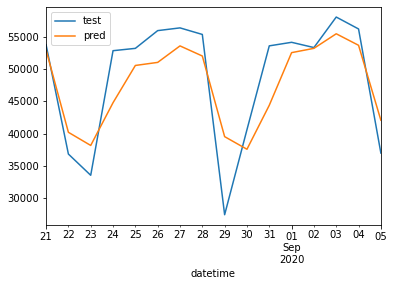

In [148]:

pred = results.predict(te_start,te_end, exog= exog_test)
print('ARIMA model MSE:{}'.format(np.sqrt(mean_squared_error(tes['Brooklyn Battery'],pred))))
pd.DataFrame({'test':tes['Brooklyn Battery'],'pred':pred}).plot();plt.show()

ARIMA model MSE:6192.459338586512


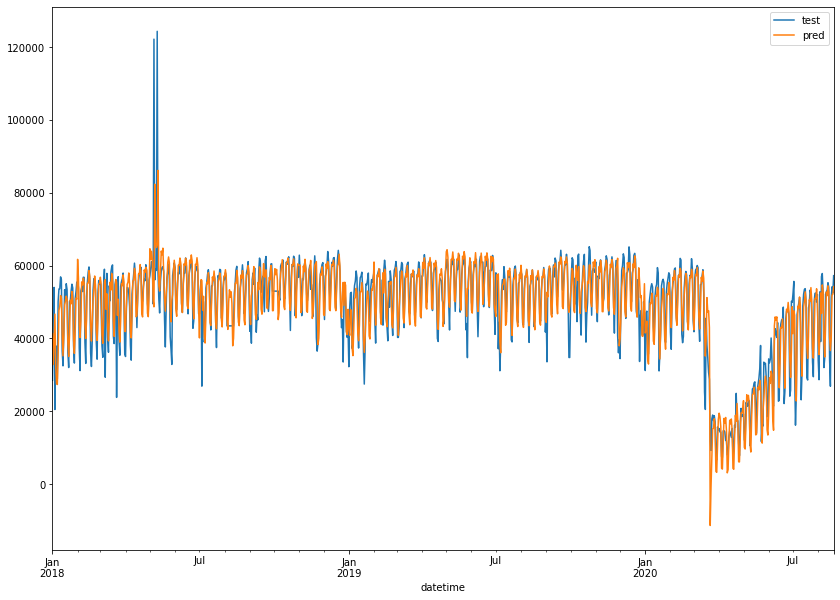

In [149]:
from sklearn.metrics import mean_squared_error
pred = results.predict(tr_start,tr_end, exog= exog_train)
print('ARIMA model MSE:{}'.format(np.sqrt(mean_squared_error(tra['Brooklyn Battery'],pred))))
pd.DataFrame({'test':tra['Brooklyn Battery'],'pred':pred}).plot(figsize=(14,10));plt.show()

ARIMA model MSE:5660.201246044165


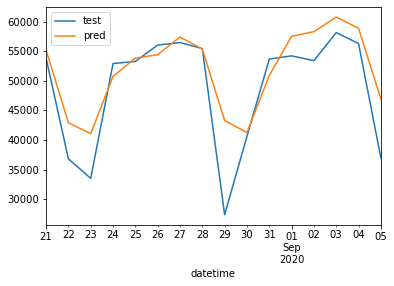

In [128]:

pred = results.predict(te_start,te_end, exog= exog_test)
print('ARIMA model MSE:{}'.format(np.sqrt(mean_squared_error(tes['Brooklyn Battery'],pred))))
pd.DataFrame({'test':tes['Brooklyn Battery'],'pred':pred}).plot();plt.show()

ARIMA model MSE:7214.93927236864


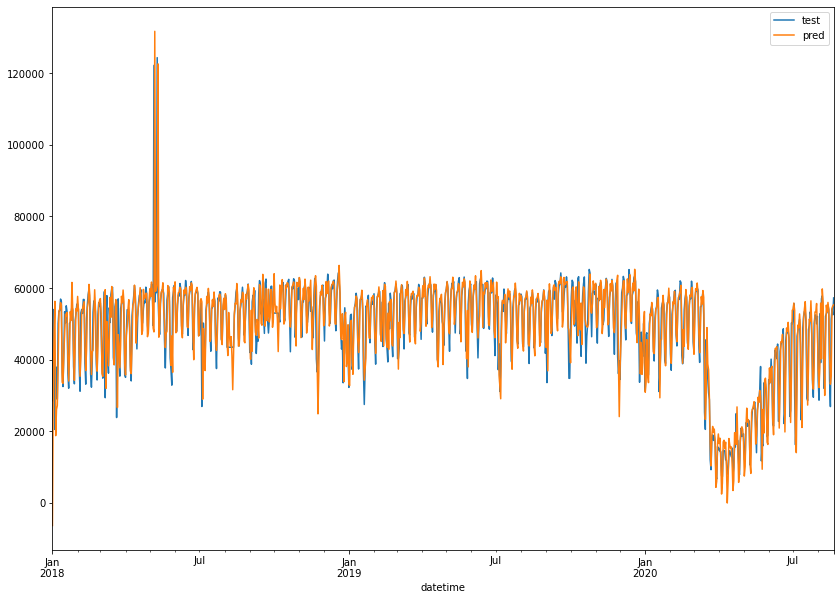

In [129]:
from sklearn.metrics import mean_squared_error
pred = results.predict(tr_start,tr_end, exog= exog_train)
print('ARIMA model MSE:{}'.format(np.sqrt(mean_squared_error(tra['Brooklyn Battery'],pred))))
pd.DataFrame({'test':tra['Brooklyn Battery'],'pred':pred}).plot(figsize=(14,10));plt.show()

In [159]:
model_SARIMAX = SARIMAX(tra['Brooklyn Battery'],order=(7,0,7),seasonal_order=(1,0,0,12), exog = exog_train, freq='D', enforce_stationarity=False, enforce_invertibility=False)
results = model_SARIMAX.fit()
results.summary()

C:\Users\albert\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                    Brooklyn Battery   No. Observations:                  963
Model:             SARIMAX(7, 0, 7)x(1, 0, [], 12)   Log Likelihood               -9534.771
Date:                             Wed, 16 Sep 2020   AIC                          19147.542
Time:                                     17:01:24   BIC                          19336.697
Sample:                                 01-01-2018   HQIC                         19219.635
                                      - 08-20-2020                                         
Covariance Type:                               opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
month_2      7635.1789   2147.267      3.556      0.000    3426.613    1.18e+04
month_3      7041.8240   1828.474      3.851      0.000    3458.080    1.06e+04
month_4      1.046e+04   2425.355      4.315      0.000    5710.688    1.52e+04
month_5      1.554e+04   1652.896      9.405      0.000    1.23e+04    1.88e+04
month_6      1.407e+04   1832.475      7.679      0.000    1.05e+04    1.77e+04
month_7      7738.9064   1833.518      4.221      0.000    4145.278    1.13e+04
month_8      8324.5449   2901.752      2.869      0.004    2637.216     1.4e+04
month_9      1.079e+04   2040.781      5.287      0.000    6790.058    1.48e+04
month_10      1.14e+04   2671.393      4.268      0.000    6165.278    1.66e+04
month_11     1.055e+04   2503.909      4.213      0.000    5640.934    1.55e+04
month_12     9914.9690   2064.732      4.802      0.000    5868.169     1.4e+04
dayofweek_1  5880.7704   1102.333      5.335      0.000    3720.237    8041.304
dayofweek_2  6460.6972   1290.985      5.004      0.000    3930.414    8990.981
dayofweek_3  8699.7196   1291.815      6.734      0.000    6167.809    1.12e+04
dayofweek_4  6932.0240   1451.250      4.777      0.000    4087.627    9776.421
dayofweek_5  -883.5435    746.761     -1.183      0.237   -2347.168     580.081
dayofweek_6 -2945.4257    554.393     -5.313      0.000   -4032.016   -1858.835
weekend_1   -3828.9692    673.855     -5.682      0.000   -5149.701   -2508.238
Phase_1      2.119e+04   3459.611      6.124      0.000    1.44e+04     2.8e+04
Phase_2      2.605e+04   3254.818      8.002      0.000    1.97e+04    3.24e+04
Phase_3      3.387e+04   5360.409      6.318      0.000    2.34e+04    4.44e+04
Phase_4      3.588e+04   3825.479      9.380      0.000    2.84e+04    4.34e+04
Phase_5      4.127e+04   1152.093     35.823      0.000     3.9e+04    4.35e+04
ar.L1           0.1676      0.140      1.199      0.230      -0.106       0.441
ar.L2          -0.4514      0.130     -3.471      0.001      -0.706      -0.196
ar.L3           0.2498      0.153      1.632      0.103      -0.050       0.550
ar.L4          -0.3497      0.120     -2.911      0.004      -0.585      -0.114
ar.L5          -0.0524      0.128     -0.409      0.682      -0.303       0.198
ar.L6          -0.0206      0.092     -0.224      0.823      -0.201       0.160
ar.L7           0.5028      0.073      6.923      0.000       0.360       0.645
ma.L1           0.2219      0.141      1.574      0.115      -0.054       0.498
ma.L2           0.5968      0.110      5.448      0.000       0.382       0.812
ma.L3          -0.0525      0.151     -0.347      0.729      -0.349       0.244
ma.L4           0.5474      0.119      4.602      0.000       0.314       0.781
ma.L5           0.1595      0.136      1.171      0.241      -0.107       0.426
ma.L6           0.3134      0.103      3.056      0.002       0.112       0.514
ma.L

ARIMA model MSE:4235.7572184631135


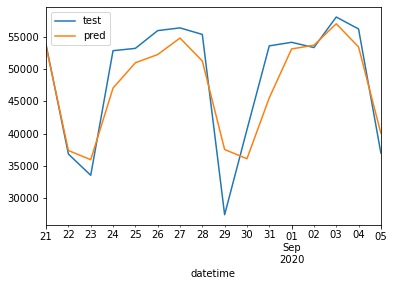

In [160]:

pred = results.predict(te_start,te_end, exog= exog_test)
print('ARIMA model MSE:{}'.format(np.sqrt(mean_squared_error(tes['Brooklyn Battery'],pred))))
pd.DataFrame({'test':tes['Brooklyn Battery'],'pred':pred}).plot();plt.show()

ARIMA model MSE:5990.379199394405


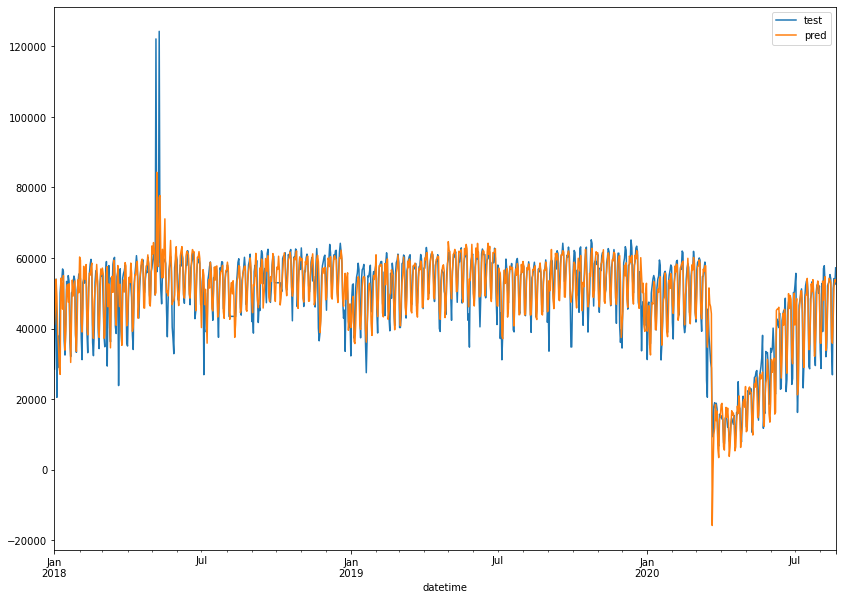

In [161]:
from sklearn.metrics import mean_squared_error
pred = results.predict(tr_start,tr_end, exog= exog_train)
print('ARIMA model MSE:{}'.format(np.sqrt(mean_squared_error(tra['Brooklyn Battery'],pred))))
pd.DataFrame({'test':tra['Brooklyn Battery'],'pred':pred}).plot(figsize=(14,10));plt.show()

In [156]:
stepwise_fit = auto_arima(_BBT_merged['Brooklyn Battery'], start_p=0, start_q=0, 
                          exogenous = _BBT_merged.drop(columns = ['Brooklyn Battery']).dropna(), 
                          information_criterion='oob',
                         max_p=8, max_q=8, m=12, out_of_sample_size=30,
                         seasonal=True,
                         d=None, trace=True,
                         error_action='ignore',   
                         suppress_warnings=True,  
                         stepwise=True)           

stepwise_fit.summary()

Performing stepwise search to minimize oob
Fit ARIMA: (0, 0, 0)x(1, 0, 1, 12) (constant=True); AIC=20116.595, BIC=20248.532, Time=7.810 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 12) (constant=True); AIC=20112.755, BIC=20234.918, Time=0.387 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 12) (constant=True); AIC=19941.379, BIC=20073.315, Time=4.381 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 12) (constant=True); AIC=19981.774, BIC=20113.710, Time=4.696 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 12) (constant=False); AIC=25858.147, BIC=25975.424, Time=0.374 seconds
Fit ARIMA: (0, 0, 0)x(1, 0, 0, 12) (constant=True); AIC=20114.523, BIC=20241.573, Time=2.551 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 1, 12) (constant=True); AIC=20114.515, BIC=20241.565, Time=2.821 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 12) (constant=True); AIC=19940.409, BIC=20067.458, Time=1.002 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 12) (constant=True); AIC=19979.912, BIC=20106.962, Time=0.962 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 12) (constant=Tr

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  979
Model:               SARIMAX(3, 0, 1)   Log Likelihood               -9936.404
Date:                Wed, 16 Sep 2020   AIC                          19930.807
Time:                        16:25:52   BIC                          20072.517
Sample:                             0   HQIC                         19984.722
                                - 979                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    198.1048    421.548      0.470      0.638    -628.113    1024.323
x1          7599.5796   2054.170      3.700      0.000    3573.480    1.16e+04
x2          6999.7528   1756.616      3.985      0.000    3556.849    1.04e+04
x3          1.042e+04   2440.907      4.267      0.000    5632.192    1.52e+04
x4           1.55e+04   1641.668      9.439      0.000    1.23e+04    1.87e+04
x5          1.403e+04   2221.343      6.318      0.000    9680.878    1.84e+04
x6          7807.8352   1905.338      4.098      0.000    4073.441    1.15e+04
x7          8182.7533   2676.421      3.057      0.002    2937.065    1.34e+04
x8          1.075e+04   2120.052      5.071      0.000    6596.314    1.49e+04
x9          1.137e+04   2521.476      4.510      0.000    6428.706    1.63e+04
x10         1.051e+04   2212.081      4.753      0.000    6178.333    1.48e+04
x11         9878.6869   1940.647      5.090      0.000    6075.088    1.37e+04
x12         5919.7283    777.359      7.615      0.000    4396.132    7443.325
x13         6517.8342    787.121      8.281      0.000    4975.106    8060.563
x14         8741.7617    713.287     12.256      0.000    7343.745    1.01e+04
x15         6985.9778    855.060      8.170      0.000    5310.091    8661.864
x16         -825.3690    445.319     -1.853      0.064   -1698.178      47.440
x17        -2880.0135    361.740     -7.962      0.000   -3589.010   -2171.017
x18        -3705.3825    385.843     -9.603      0.000   -4461.621   -2949.143
x19         2.114e+04   3903.463      5.417      0.000    1.35e+04    2.88e+04
x20         2.596e+04   3095.242      8.388      0.000    1.99e+04     3.2e+04
x21         3.372e+04   3773.953      8.936      0.000    2.63e+04    4.11e+04
x22         3.522e+04   3108.675     11.331      0.000    2.91e+04    4.13e+04
x23         4.123e+04   1474.153     27.966      0.000    3.83e+04    4.41e+04
ar.L1          0.9059      0.234      3.864      0.000       0.446       1.365
ar.L2         -0.1598      0.087     -1.831      0.067      -0.331       0.011
ar.L3          0.0489      0.046      1.058      0.290      -0.042       0.140
ma.L1         -0.5473      0.238     -2.296      0.022      -1.014      -0.080
sigma2      3.766e+07      2.860   1.32e+07      0.000    3.77e+07    3.77e+07
===================================================================================
Ljung-Box (Q):                       97.69   Jarque-Bera (JB):             38341.51
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                             1.48
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.5e+22. Standard errors may be unstab

In [157]:
model_SARIMAX = SARIMAX(tra['Brooklyn Battery'],order=(3,0,1), exog = exog_train, freq='D', enforce_stationarity=False, enforce_invertibility=False)
results = model_SARIMAX.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Brooklyn Battery   No. Observations:                  963
Model:               SARIMAX(3, 0, 1)   Log Likelihood               -9738.945
Date:                Wed, 16 Sep 2020   AIC                          19533.889
Time:                        16:28:05   BIC                          19670.163
Sample:                    01-01-2018   HQIC                         19585.785
                         - 08-20-2020                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
month_2      7635.1790   2065.628      3.696      0.000    3586.623    1.17e+04
month_3      7041.8240   1664.102      4.232      0.000    3780.244    1.03e+04
month_4      1.046e+04   2362.893      4.429      0.000    5833.111    1.51e+04
month_5      1.554e+04   1502.115     10.349      0.000    1.26e+04    1.85e+04
month_6      1.407e+04   1951.413      7.211      0.000    1.02e+04    1.79e+04
month_7      7738.9065   1771.081      4.370      0.000    4267.651    1.12e+04
month_8      8324.5449   2748.580      3.029      0.002    2937.426    1.37e+04
month_9      1.079e+04   2123.106      5.082      0.000    6628.704     1.5e+04
month_10      1.14e+04   2591.747      4.399      0.000    6321.380    1.65e+04
month_11     1.055e+04   2371.566      4.448      0.000    5900.322    1.52e+04
month_12     9914.9691   1968.790      5.036      0.000    6056.211    1.38e+04
dayofweek_1  5880.7702    784.010      7.501      0.000    4344.140    7417.401
dayofweek_2  6460.6964    790.063      8.177      0.000    4912.202    8009.191
dayofweek_3  8699.7195    799.944     10.875      0.000    7131.858    1.03e+04
dayofweek_4  6932.0242    874.641      7.926      0.000    5217.759    8646.290
dayofweek_5  -883.5443    450.654     -1.961      0.050   -1766.809      -0.279
dayofweek_6 -2945.4260    360.500     -8.170      0.000   -3651.993   -2238.859
weekend_1   -3828.9702    386.315     -9.912      0.000   -4586.133   -3071.807
Phase_1      2.119e+04   3887.166      5.451      0.000    1.36e+04    2.88e+04
Phase_2      2.605e+04   3113.174      8.366      0.000    1.99e+04    3.21e+04
Phase_3      3.387e+04   3796.594      8.920      0.000    2.64e+04    4.13e+04
Phase_4      3.588e+04   3365.012     10.663      0.000    2.93e+04    4.25e+04
Phase_5      4.127e+04   1125.121     36.682      0.000    3.91e+04    4.35e+04
ar.L1           1.0799      0.084     12.854      0.000       0.915       1.245
ar.L2          -0.2136      0.046     -4.606      0.000      -0.305      -0.123
ar.L3           0.0180      0.037      0.485      0.628      -0.055       0.091
ma.L1          -0.7187      0.082     -8.714      0.000      -0.880      -0.557
sigma2       3.755e+07      2.434   1.54e+07      0.000    3.76e+07    3.76e+07
===================================================================================
Ljung-Box (Q):                       88.80   Jarque-Bera (JB):             40330.22
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                             1.59
Prob(H) (two-sided):                  0.00   Kurtosis:                        34.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.41e+22. Standard errors may be unstable.
"""

ARIMA model MSE:5273.909921041971


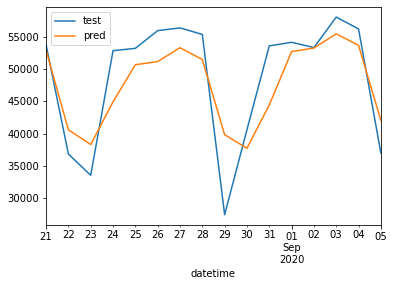

In [158]:

pred = results.predict(te_start,te_end, exog= exog_test)
print('ARIMA model MSE:{}'.format(np.sqrt(mean_squared_error(tes['Brooklyn Battery'],pred))))
pd.DataFrame({'test':tes['Brooklyn Battery'],'pred':pred}).plot();plt.show()

In [167]:
_df_unstack[tr_start:tr_end][_df_unstack.columns]

plaza_id,Brooklyn Battery,Cross Bay,Henry Hudson,Marine Parkway,Quessn Midtown,Throgs Neck,Triboro Bronx,Triboro Manhattan,Verrazano,Whitestone
datetime,,,,,,,,,,
2018-01-01,28500,13226,45681,11729,53427,96408,107518,29590,79469,106796
2018-01-02,47160,21875,60610,19887,67000,106264,129574,35356,95649,117211
2018-01-03,54005,24607,67983,22067,71725,115952,136213,38937,103506,123974
2018-01-04,20484,8303,14502,6167,26625,28406,50867,13270,37820,38114
2018-01-05,38007,16839,49850,13929,55153,80477,105945,29308,74375,91229
...,...,...,...,...,...,...,...,...,...,...
2020-08-16,26879,15202,37782,13619,38633,99398,93731,23597,77490,110050
2020-08-17,51279,23792,57126,23598,61322,104633,124727,35222,97862,120060
2020-08-18,54168,28077,58655,27903,65767,108104,125650,35351,101007,123407


In [165]:
exog_train

,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,...,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,weekend_1,Phase_1,Phase_2,Phase_3,Phase_4,Phase_5
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2018-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2018-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2018-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2018-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-16,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2020-08-17,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2020-08-18,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [183]:
for i in exog_train.columns:
    exog_train[i] = exog_train[i].astype('float')

In [184]:
exog_train

,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,...,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,weekend_1,Phase_1,Phase_2,Phase_3,Phase_4,Phase_5
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2018-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2018-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2018-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2018-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-16,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2020-08-17,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2020-08-18,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [188]:
for i in _df_unstack.columns:
    _df_unstack[i] = _df_unstack[i].astype('float')

In [193]:
_df_unstack[tr_start:tr_end][['Brooklyn Battery', 'Cross Bay']]

plaza_id,Brooklyn Battery,Cross Bay
datetime,,
2018-01-01,28500.0,13226.0
2018-01-02,47160.0,21875.0
2018-01-03,54005.0,24607.0
2018-01-04,20484.0,8303.0
2018-01-05,38007.0,16839.0
...,...,...
2020-08-16,26879.0,15202.0
2020-08-17,51279.0,23792.0
2020-08-18,54168.0,28077.0


In [186]:
exog_train.dtypes

month_2        float64
month_3        float64
month_4        float64
month_5        float64
month_6        float64
month_7        float64
month_8        float64
month_9        float64
month_10       float64
month_11       float64
month_12       float64
dayofweek_1    float64
dayofweek_2    float64
dayofweek_3    float64
dayofweek_4    float64
dayofweek_5    float64
dayofweek_6    float64
weekend_1      float64
Phase_1        float64
Phase_2        float64
Phase_3        float64
Phase_4        float64
Phase_5        float64
dtype: object

In [194]:
model_VARMAX = sm.tsa.VARMAX(_df_unstack[tr_start:tr_end][['Brooklyn Battery', 'Cross Bay']],
                             order=(2,0), trend = 'n',exog = exog_train, enforce_stationarity=False, enforce_invertibility=False)
results = model_VARMAX.fit(maxiter=1000, disp=True)
results.summary()

Dep. Variable:,"['Brooklyn Battery', 'Cross Bay']",No. Observations:,963
Model:,VARX(2),Log Likelihood,-18817.376
Date:,"Wed, 16 Sep 2020",AIC,37748.751
Time:,17:29:01,BIC,38026.344
Sample:,01-01-2018,HQIC,37854.449
,- 08-20-2020,,
Covariance Type:,opg,,
Ljung-Box (Q):,"363.73, 361.67",Jarque-Bera (JB):,"21107.39, 22942.78"
Prob(Q):,"0.00, 0.00",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"0.55, 0.83",Skew:,"1.17, 2.34"
Prob(H) (two-sided):,"0.00, 0.09",Kurtosis:,"25.82, 26.45"


In [195]:
pred = results.predict(te_start,te_end, exog= exog_test)
pred

,Brooklyn Battery,Cross Bay
2020-08-21,52031.585547,26585.460055
2020-08-22,44640.491148,25016.258564
2020-08-23,40944.291751,23263.018727
2020-08-24,43681.210924,22742.590327
2020-08-25,47840.920490,24226.582570
2020-08-26,49322.821875,24948.396889
2020-08-27,51231.775888,25643.653438
2020-08-28,51045.343682,26247.870182
2020-08-29,44490.960670,24846.563112
2020-08-30,40888.012276,23180.117178


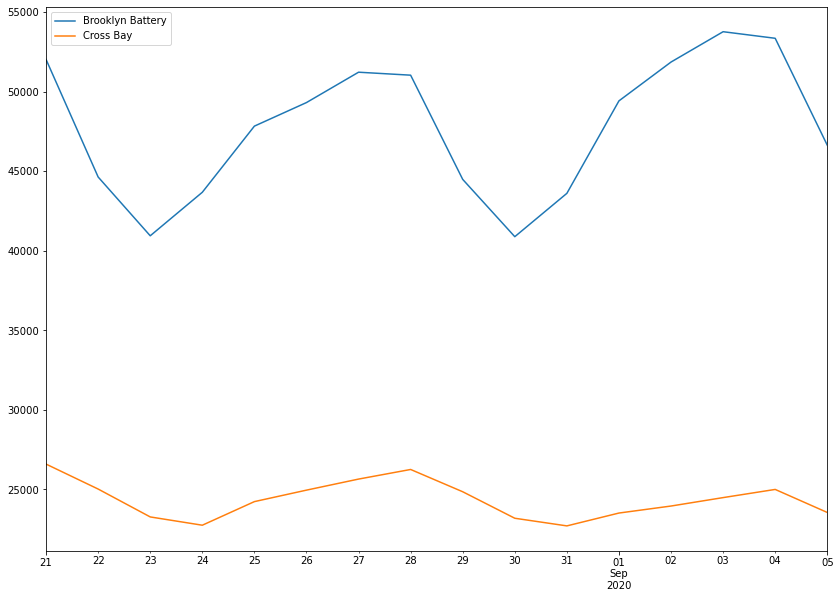

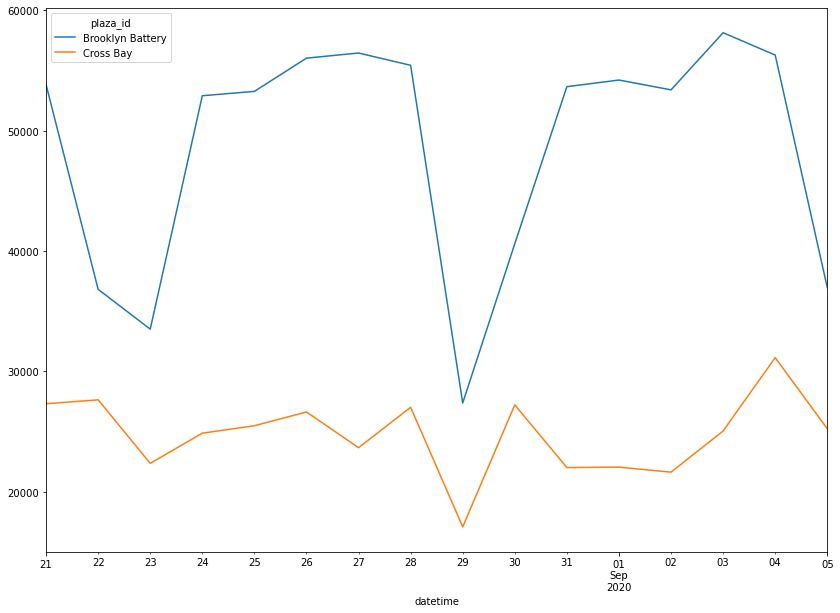

In [198]:
pred.plot(figsize=(14,10))
_df_unstack[te_start:te_end][['Brooklyn Battery', 'Cross Bay']].plot(figsize=(14,10))

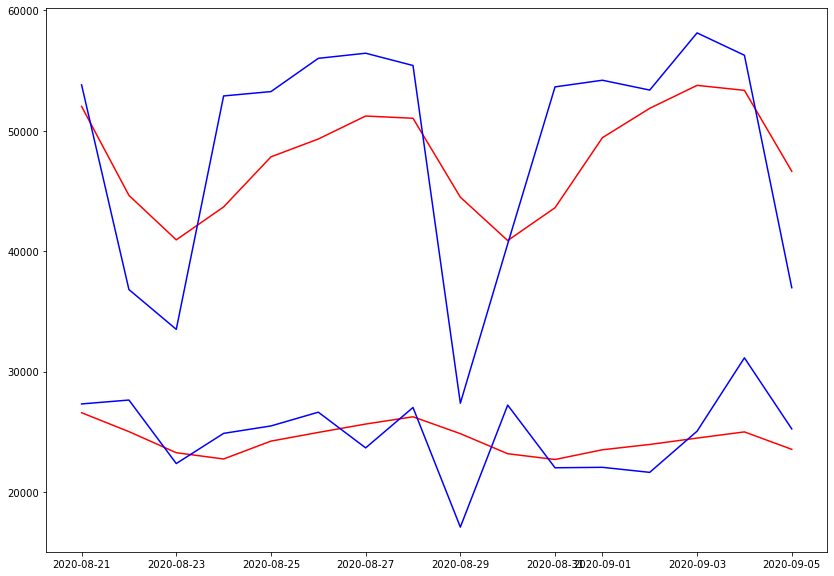

In [203]:
plt.figure(figsize=(14,10))
plt.plot(pred, color='red')
plt.plot(_df_unstack[te_start:te_end][['Brooklyn Battery', 'Cross Bay']], color='blue')

In [206]:
model_VARMAX = sm.tsa.VARMAX(_df_unstack[tr_start:tr_end][['Brooklyn Battery', 'Cross Bay']],
                             order=(1,1), trend = 'n',exog = exog_train, enforce_stationarity=False, enforce_invertibility=False)
results = model_VARMAX.fit(maxiter=1000, disp=True)
results.summary()

C:\Users\albert\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


Dep. Variable:,"['Brooklyn Battery', 'Cross Bay']",No. Observations:,963
Model:,"VARMAX(1,1)",Log Likelihood,-18816.637
Date:,"Wed, 16 Sep 2020",AIC,37747.273
Time:,17:39:47,BIC,38024.866
Sample:,01-01-2018,HQIC,37852.971
,- 08-20-2020,,
Covariance Type:,opg,,
Ljung-Box (Q):,"361.08, 349.62",Jarque-Bera (JB):,"20202.69, 23915.03"
Prob(Q):,"0.00, 0.00",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"0.59, 0.89",Skew:,"1.16, 2.44"
Prob(H) (two-sided):,"0.00, 0.30",Kurtosis:,"25.32, 26.92"


C:\Users\albert\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\albert\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


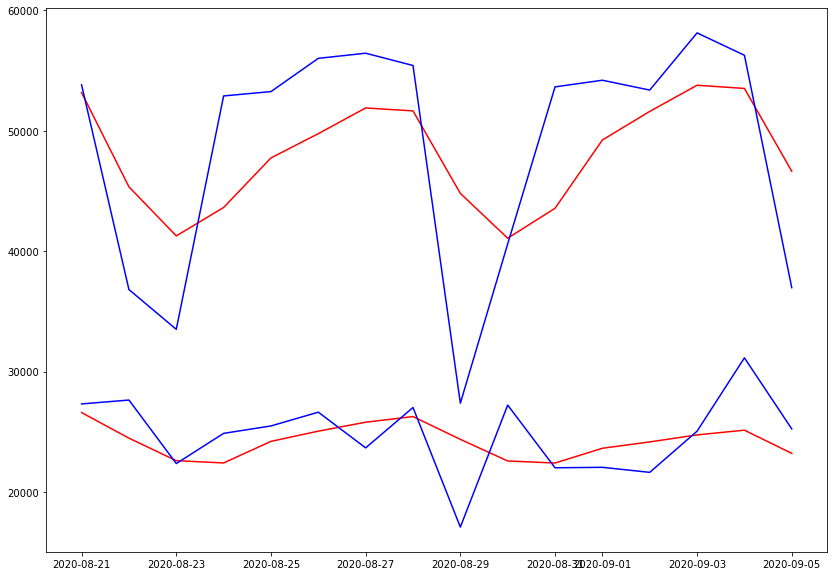

In [207]:
pred = results.predict(te_start,te_end, exog= exog_test)
plt.figure(figsize=(14,10))
plt.plot(pred, color='red')
plt.plot(_df_unstack[te_start:te_end][['Brooklyn Battery', 'Cross Bay']], color='blue')

In [208]:
pred

,Brooklyn Battery,Cross Bay
2020-08-21,53176.997788,26597.932046
2020-08-22,45350.966966,24471.624994
2020-08-23,41273.401428,22602.826600
2020-08-24,43633.501975,22412.115379
2020-08-25,47752.681496,24206.462859
2020-08-26,49767.264698,25054.514825
2020-08-27,51901.901921,25797.539693
2020-08-28,51657.429383,26265.793724
2020-08-29,44805.418428,24373.132228
2020-08-30,41082.099140,22577.068302


In [211]:
for i in pred.columns:
    print('rmse value ', i, ' is', np.sqrt(mean_squared_error(pred[i],_df_unstack[te_start:te_end][i])))

rmse value  Brooklyn Battery  is 7404.931363245473
rmse value  Cross Bay  is 3061.2165271238355


In [212]:
model_VARMAX = sm.tsa.VARMAX(_df_unstack[tr_start:tr_end][['Brooklyn Battery', 'Cross Bay']],
                             order=(3,1), trend = 'c',exog = exog_train, enforce_stationarity=False, enforce_invertibility=False)
results = model_VARMAX.fit(maxiter=1000, disp=True)
results.summary()

C:\Users\albert\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


Dep. Variable:,"['Brooklyn Battery', 'Cross Bay']",No. Observations:,963
Model:,"VARMAX(3,1)",Log Likelihood,-18714.700
,+ intercept,AIC,37563.400
Date:,"Wed, 16 Sep 2020",BIC,37889.694
Time:,18:07:45,HQIC,37687.641
Sample:,01-01-2018,,
,- 08-20-2020,,
Covariance Type:,opg,,
Ljung-Box (Q):,"233.90, 244.15",Jarque-Bera (JB):,"32889.92, 42092.22"
Prob(Q):,"0.00, 0.00",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"0.52, 0.73",Skew:,"1.43, 3.13"


C:\Users\albert\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\albert\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


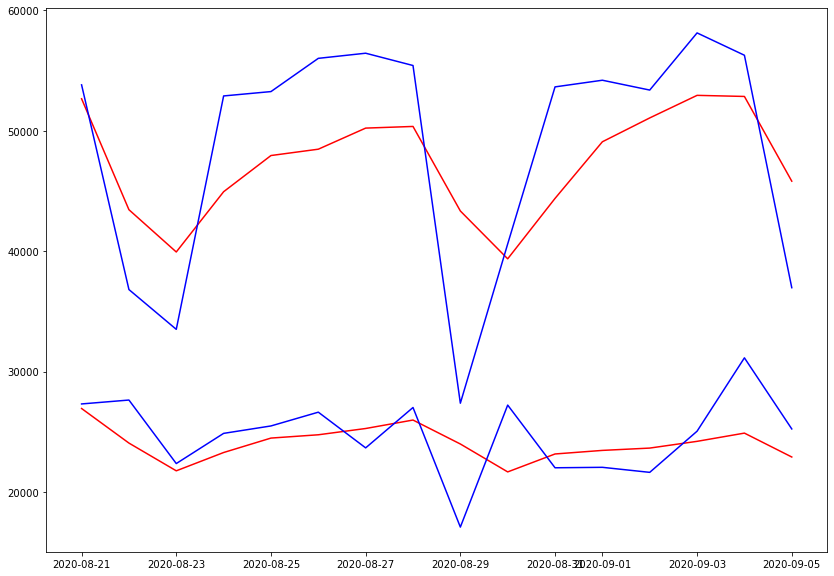

In [213]:
pred = results.predict(te_start,te_end, exog= exog_test)
plt.figure(figsize=(14,10))
plt.plot(pred, color='red')
plt.plot(_df_unstack[te_start:te_end][['Brooklyn Battery', 'Cross Bay']], color='blue')

In [214]:
for i in pred.columns:
    print('rmse value ', i, ' is', np.sqrt(mean_squared_error(pred[i],_df_unstack[te_start:te_end][i])))

rmse value  Brooklyn Battery  is 7027.3860345578105
rmse value  Cross Bay  is 3113.4057730365416


In [215]:
model_VARMAX = sm.tsa.VARMAX(_df_unstack[tr_start:tr_end][['Brooklyn Battery', 'Cross Bay']],
                             order=(3,1), trend = 'c',exog = exog_train, enforce_stationarity=False, enforce_invertibility=False)
results = model_VARMAX.fit()
results.summary()

C:\Users\albert\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\albert\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Dep. Variable:,"['Brooklyn Battery', 'Cross Bay']",No. Observations:,963
Model:,"VARMAX(3,1)",Log Likelihood,-18717.524
,+ intercept,AIC,37569.047
Date:,"Wed, 16 Sep 2020",BIC,37895.341
Time:,18:09:55,HQIC,37693.289
Sample:,01-01-2018,,
,- 08-20-2020,,
Covariance Type:,opg,,
Ljung-Box (Q):,"265.84, 241.15",Jarque-Bera (JB):,"31339.41, 41925.68"
Prob(Q):,"0.00, 0.00",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"0.54, 0.71",Skew:,"1.44, 3.10"


C:\Users\albert\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\albert\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


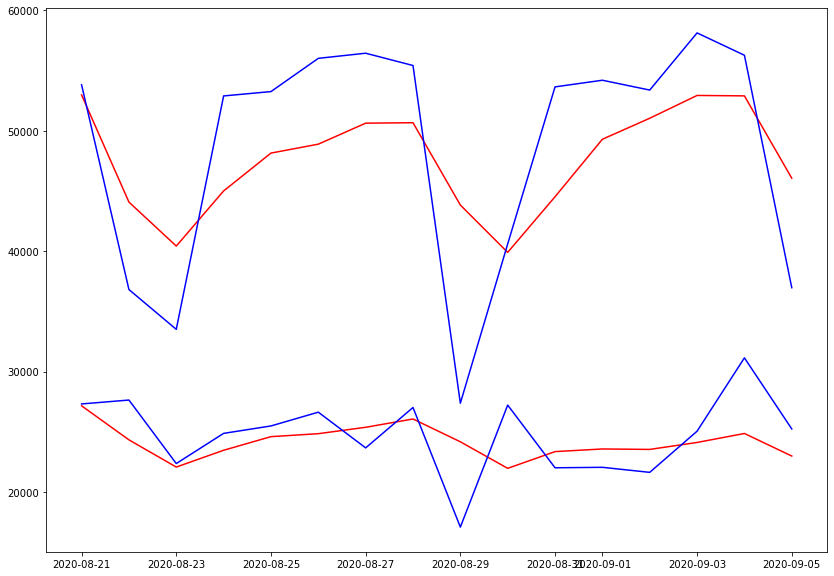

In [216]:
pred = results.predict(te_start,te_end, exog= exog_test)
plt.figure(figsize=(14,10))
plt.plot(pred, color='red')
plt.plot(_df_unstack[te_start:te_end][['Brooklyn Battery', 'Cross Bay']], color='blue')

In [217]:
for i in pred.columns:
    print('rmse value ', i, ' is', np.sqrt(mean_squared_error(pred[i],_df_unstack[te_start:te_end][i])))

rmse value  Brooklyn Battery  is 7081.133135599815
rmse value  Cross Bay  is 3080.5037251302947
